In [1]:
# pip install psycopg2 pandas

In [2]:
# pip install python-dotenv psycopg2


### Connection Details

In [136]:
import os
from sqlalchemy import create_engine, text
from sqlalchemy.exc import OperationalError 
from dotenv import load_dotenv
import pandas as pd

def get_database_connection(env_path: str = ".env") -> 'sqlalchemy.engine.base.Engine':
    """
    Creates and returns a database connection engine using credentials from an .env file.
    Validates the connection by executing a simple query.
    """
    
    def test_connection(engine: 'sqlalchemy.engine.base.Engine') -> bool:
        """
        Tests the database connection by executing a simple query.
        """
        with engine.connect() as connection:
            connection.execute(text("SELECT 1"))
        return True


    load_dotenv(env_path)

    db_config = {
        "username": os.getenv("DB_USERNAME"),
        "password": os.getenv("DB_PASSWORD"),
        "host": os.getenv("DB_HOST", "localhost"),  # Default to localhost
        "port": os.getenv("DB_PORT", "5432"),       # Default to 5432
        "database": os.getenv("DB_DATABASE"),
    }

    missing_keys = [key for key, value in db_config.items() if value is None]
    if missing_keys:
        raise ValueError(f"Missing required database configuration keys: {', '.join(missing_keys)}")

    engine = create_engine(
        f"postgresql://{db_config['username']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
    )

    #Testing the connection
    try:
        test_connection(engine)
        print("Database connection tested successfully!")
    except OperationalError as e:
        raise ConnectionError(f"Database connection test failed: {e}")

    return engine


In [137]:
def fetch_table_db(engine, query) -> pd.DataFrame:
    """
    Fetches two tables from the database, joins them, and returns the result as a DataFrame.
    """
    try:
        df = pd.read_sql(query, engine)
        print("Data fetched successfully")
        return df
    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.DataFrame() 
        
def insert_data(engine, df, table):
    try:
        df.to_sql(table, engine, index=False, if_exists='append', method='multi')
        print(f"Data successfully inserted into {table} table.")
    except Exception as e:
        print(f"Error inserting data into {table}: {e}")

In [138]:
engine = get_database_connection()
# ! jupyter notebook --ServerApp.iopub_data_rate_limit=10000000


Database connection tested successfully!


#### Data Transformation

#### 1. Write queries to transform the two tables into one table having one row per message.

#### Below query retrieves the latest status for each message by joining the l0_messages table with the l0_statuses table, using ROW_NUMBER() to rank statuses by their update time. It returns the most recent status for each message along with relevant message details

In [172]:
query1 = """
            WITH status AS (
                SELECT 
                    id AS status_id, 
                    status, 
                    timestamp, 
                    uuid AS status_uuid, 
                    message_uuid, 
                    number_id, 
                    inserted_at, 
                    updated_at, 
                    ROW_NUMBER() OVER (PARTITION BY message_uuid ORDER BY updated_at DESC) AS rnk
                FROM l0_statuses
            )
            SELECT 
                    m.id AS message_id, 
                    m.content, 
                    m.message_type, 
                    m.masked_addressees, 
                    m.masked_from_addr,
                    m.direction, 
                    m.external_id, 
                    m.external_timestamp, 
                    m.is_deleted,
                    m.last_status, 
                    m.last_status_timestamp, 
                    m.rendered_content, 
                    m.uuid AS message_uuid,
                    m.inserted_at as message_inserted_at, 
                    m.updated_at as message_updated_at, 
                    m.masked_author, 
                    m.author_type,
                    m.source_type,  
                    s.status_id, 
                    s.status, 
                    s.timestamp as status_timestamp, 
                    s.status_uuid, 
                    s.message_uuid as message_status_uuid, 
                    s.number_id, 
                    s.inserted_at as message_status_inserted_at, 
                    s.updated_at as message_status_updated_at 
                FROM l0_messages m 
                LEFT JOIN (SELECT * from status where rnk = 1) s ON m.uuid = s.message_uuid;
    """

In [173]:
join_df = fetch_table_db(engine,query1)
join_df[join_df['direction']=='inbound']

Data fetched successfully


,message_id,content,message_type,masked_addressees,masked_from_addr,direction,external_id,external_timestamp,is_deleted,last_status,...,author_type,source_type,status_id,status,status_timestamp,status_uuid,message_status_uuid,number_id,message_status_inserted_at,message_status_updated_at
0,225827003,छठे माह के बच्चे को क्या दाल का पानी पीला सकते...,text,8316157823254039726,360699995903664615,inbound,ABEGkYmCWHJiAhAYMP42_69FGA2CoT8e0Igw,2021-09-09 17:25:00.000,None,None,...,OWNER,CHANNEL_MESSAGE,NaN,None,NaT,None,None,None,NaT,NaT
1,290238495,Ha ek per normal hai,text,8316157823254039726,1924410226241906500,inbound,ABEGkYh4aZgWAhCc0KJxm2sPNBWXkl8UYqXC,2022-06-01 08:26:28.000,None,None,...,OWNER,CHANNEL_MESSAGE,NaN,None,NaT,None,None,None,NaT,NaT
3,286769759,None,voice,8316157823254039726,2372380464914471916,inbound,ABEGkZORIpkWAghHCYh-gowJvw,2022-05-10 15:43:33.000,None,None,...,OWNER,CHANNEL_MESSAGE,NaN,None,NaT,None,None,None,NaT,NaT
4,810101715,Hk,text,8316157823254039726,7716078790004740279,inbound,wamid.HBgMOTE5NzAxOTc5MjYxFQIAEhggQ0Y0OEJGOUM1...,2024-03-31 16:36:11.000,None,None,...,OWNER,CHANNEL_MESSAGE,NaN,None,NaT,None,None,None,NaT,NaT
6,200616477,Khri sarkari scheme aa ji,text,3301580771866412427,99406278043849801,inbound,ABEGkZd5cgOJAhDNLGabLS98ypJTnsVAFkfK,2021-05-28 15:57:33.201,None,None,...,OWNER,CHANNEL_MESSAGE,NaN,None,NaT,None,None,None,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3210,722353501,Kuch infaction hogya h kya,text,8316157823254039726,1413503464614001621,inbound,ABEGkWIyh4ckAhDvF0bobIfoD1_hr-r4Onio,2024-01-13 21:10:51.000,None,None,...,OWNER,CHANNEL_MESSAGE,NaN,None,NaT,None,None,None,NaT,NaT
3211,648440641,None,text,8316157823254039726,6265043104492981808,inbound,ABEGkYiJQEFRAhAbqXBtpnlGk1jqoRAMHh-v,2023-11-06 18:52:12.000,None,None,...,OWNER,CHANNEL_MESSAGE,NaN,None,NaT,None,None,None,NaT,NaT
3212,671581374,Manju,text,8316157823254039726,5559927377690657409,inbound,ABEGkZMBZUEkAhDvmLU9xW3kehFr6DKZtz9K,2023-11-20 03:31:46.000,None,None,...,OWNER,CHANNEL_MESSAGE,NaN,None,NaT,None,None,None,NaT,NaT
3213,583415251,👍🏻,text,8316157823254039726,5894953256185105314,inbound,ABEGkXJgkGOXAhBlYtuVCqpD2aUyVNnWpEe5,2023-10-08 03:34:55.000,None,None,...,OWNER,CHANNEL_MESSAGE,NaN,None,NaT,None,None,None,NaT,NaT


In [174]:
insert_data(engine, join_df,'l1_message_status')

Data successfully inserted into l1_message_status table.


#### 2. Write a query to detect and flag duplicate records based on identical content and similar inserted_at timestamps.

##### Here I'm ranking messages by content for inbound and rendered content for outbound messages, partitioned by the minute of insertion, and flags duplicate messages within the same minute based on their rank
##### a. DATE_TRUNC - to truncate the timestamp till minute level, making seconds "00" for any give timestamp
##### b. ROW_NUMBER() - to rank every row as unique as possible based on content/rendered_content and inserted_at

In [175]:
query2 = """
            WITH rnk_message_status AS (
            SELECT 
                * ,
                ROW_NUMBER() OVER (
                    PARTITION BY 
                        CASE 
                            WHEN direction = 'inbound' THEN content 
                            WHEN direction = 'outbound' THEN rendered_content 
                            ELSE NULL 
                        END, 
                        DATE_TRUNC('minute', message_inserted_at)
                ) AS rnk
            FROM l1_message_status
        )
        SELECT 
            id,
            message_id,
            content,
            message_type,
            masked_addressees,
            masked_from_addr,
            direction,
            external_id,
            external_timestamp,
            is_deleted,
            last_status,
            last_status_timestamp,
            rendered_content,
            message_uuid,
            message_inserted_at,
            message_updated_at,
            masked_author,
            author_type,
            source_type,
            status_id,
            status,
            status_timestamp,
            status_uuid,
            message_status_uuid,
            number_id,
            message_status_inserted_at,
            message_status_updated_at,
            CASE WHEN rnk = 1 THEN FALSE ELSE TRUE END AS is_duplicated
        FROM rnk_message_status;

    """

In [176]:
query2_df = fetch_table_db(engine,query2)
query2_df[query2_df['is_duplicated']==True].head()

Data fetched successfully


,id,message_id,content,message_type,masked_addressees,masked_from_addr,direction,external_id,external_timestamp,is_deleted,...,source_type,status_id,status,status_timestamp,status_uuid,message_status_uuid,number_id,message_status_inserted_at,message_status_updated_at,is_duplicated
74,47207,607366733,None,template,6112062954639013532,4454300900215722365,outbound,gBEGkZaRICgQAgk8LNn2I1U6nM8,NaT,None,...,CHANNEL_MESSAGE,648214959.0,read,2023-10-18 19:07:53,1be35a2e-e329-4535-afd1-3022824f2224,9c440953-41cf-4063-39e8-9a2a5ce4b839,182,2023-10-18 19:07:53.942,2023-10-18 19:07:53.942,True
78,47247,634735867,None,template,4196607160218776177,4454300900215722365,outbound,gBEGkXBnEmFAAgluBcQRpzIn8s4,NaT,None,...,CHANNEL_MESSAGE,680418883.0,read,2023-10-31 10:05:11,bf390b50-7589-41c8-b058-a3d567995465,3ff5f11a-b7a4-761e-e260-8c7a70bfdb30,182,2023-10-31 10:05:11.566,2023-10-31 10:05:11.566,True
81,47258,637227237,None,template,927857004338346442,4454300900215722365,outbound,gBEGkWAFEZgwAgnfCGdmnwVolmg,NaT,None,...,CHANNEL_MESSAGE,682258319.0,read,2023-11-01 02:34:58,24e8c460-2a7d-4d98-a0b0-5e01e88e0e1b,44824301-4d8b-0c3e-9661-17d9f8a7557d,182,2023-11-01 02:34:58.103,2023-11-01 02:34:58.103,True
88,47260,665815799,None,template,3843641660206371448,4454300900215722365,outbound,gBEGkZNAVlCXAgliUZzvjW-kVI8,NaT,None,...,CHANNEL_MESSAGE,715968713.0,delivered,2023-11-16 18:32:38,5221571e-86c5-4f21-85f5-e1ef60461b48,bbca1020-e8bf-7d36-d8ff-54f9a7428aad,182,2023-11-16 18:32:39.137,2023-11-16 18:32:39.137,True
90,47237,671287504,None,template,7467686986909296304,4454300900215722365,outbound,gBEGkWJhBwOEAgmgeC1K4eRKWLU,NaT,None,...,CHANNEL_MESSAGE,726628227.0,read,2023-11-22 07:19:52,d52b50fc-353b-4230-8b5d-c230af82181d,c4097a73-f063-ee74-5014-1f0d638a5a02,182,2023-11-22 07:19:52.806,2023-11-22 07:19:52.806,True


#### Data Validation

#### 3. Include at least three additional data validation queries to check for consistency, quality, etc. of the data.

##### Validation 1 : Validate that every message_uuid in the status table has a corresponding uuid in the messages table

In [152]:
val_query1 = """
            SELECT s.message_uuid
            FROM l0_statuses s
            LEFT JOIN l0_messages m ON s.message_uuid = m.uuid
            WHERE m.uuid IS NULL;
        """
val1_df = fetch_table_db(engine,val_query1)

if val1_df.empty:
    print("Validation Successful: All message UUIDs have related data in the statuses table.")
else:
    print("Validation Failed: The following message UUIDs do not have related data in the statuses table:")
    print(val1_df.head(10))


Data fetched successfully
Validation Successful: All message UUIDs have related data in the statuses table.


##### Validation 2: Ensure direction is either "inbound" or "outbound

In [153]:

val_query2 = """
            SELECT * 
            FROM l0_messages 
            WHERE direction NOT IN ('inbound', 'outbound');
            """
val2_df = fetch_table_db(engine,val_query2)

if val2_df.empty:
    print("Validation Successful.")
else:
    print("Validation Failed: The following dataset has direction other than inbound and outbound")
    print(val2_df.head(10))

Data fetched successfully
Validation Successful.


##### Validation 3: content must be non-null for inbound messages, and rendered_content must be non-null for outbound messages.

In [154]:
val_query3 = """
            SELECT * 
            FROM l0_messages 
            WHERE 
                (direction = 'inbound' AND content IS NULL) 
                OR 
                (direction = 'outbound' AND rendered_content IS NULL);
            """

val3_df = fetch_table_db(engine,val_query3)

if val3_df.empty:
    print("Validation Successful.")
else:
    print("Validation Failed: The following dataset has content null for inbound messages or rendered_content null for outbound messages")
    print(val3_df[["uuid","content","rendered_content", "direction"]].head(10))

Data fetched successfully
Validation Failed: The following dataset has content null for inbound messages or rendered_content null for outbound messages
                                   uuid  \
0  9b888dc2-570d-5296-91b2-422fd74ea6db   
1  d69f4904-7f50-7738-aa15-ffdf2e19cef0   
2  98f18815-6aa7-732c-a109-f3265378d33e   
3  a52e72a8-0b1b-370c-1c10-e303bb9a2cd2   
4  486ad13f-242a-0c03-d1c7-bf61b4a5f856   
5  1d16b5af-3b2b-ede2-545e-26fc20ac0245   
6  91c180e2-fe84-362f-3c74-b63dbe241804   
7  6e78d4f9-3d55-f66d-c60a-066697cf44f7   
8  621611aa-16f0-63b1-503e-794501d70757   
9  62090571-b847-d81b-31eb-e15828cea0b8   

                                             content rendered_content  \
0  ⚠️निम्नलिखित लेबर (प्रसव पीड़ा) के लक्षण हैं ⚠️...             None   
1                                               None             None   
2                                              hello             None   
3                                               None             None   
4        

#### Validation 4: Ensure that uuid are unique and non-null in messages

In [155]:

val_query4= """
            SELECT uuid, COUNT(*) as count
            FROM l0_messages 
            GROUP BY uuid 
            HAVING COUNT(*) > 1;
            """
val4_df = fetch_table_db(engine,val_query4)

if val4_df.empty:
    print("Validation Successful.")
else:
    print("Validation Failed: uuid is null or not unique")
    print(val4_df.head(10))

Data fetched successfully
Validation Successful.


##### Validation 5: Status should be within the given options

In [156]:

val_query5 = """  
            SELECT * 
            FROM l0_statuses 
            WHERE status NOT IN ('sent', 'delivered', 'read','failed','deleted');
            """
val5_df = fetch_table_db(engine,val_query5)

if val5_df.empty:
    print("Validation Successful.")
else:
    print("Validation Failed")
    print(val5_df[val5_df['status'].isin(['sent', 'delivered', 'read','failed','deleted'])].head(10))

Data fetched successfully
Validation Successful.


### Visualization

##### 1. The number of total and active users over time, for a selected time 
range (e.g., per week for the last 3 months). Total users are those tha 
sent or received a message. Active users are those that send us a
message (inbound).

##### a. As we don't have latest records I'm using the maximum (latest) message update date from the l1_message_status table to use as the reference point for the time range
##### b. Filtering the data to only include records within the last 12 weeks based on the end_date from the max_date CTE
##### c. Counting the number of distinct users (total users) for each week using weekly_data CTE
##### d. Counting the number of distinct active users (those who sent an inbound message) for each week using weekly_data CTE.
##### e. Joining the total_users and active_users CTEs on the week column, showing the total and active users per week, with a default of 0 active users if no active users are found for a given week

Data fetched successfully
                        week  total_users  active_users
0  2024-01-28 18:30:00+00:00           28            27
1  2024-02-04 18:30:00+00:00           21            20
2  2024-02-11 18:30:00+00:00           28            27
3  2024-02-18 18:30:00+00:00           27            26
4  2024-02-25 18:30:00+00:00           20            19
5  2024-03-03 18:30:00+00:00           38            37
6  2024-03-10 18:30:00+00:00           44            43
7  2024-03-17 18:30:00+00:00           55            54
8  2024-03-24 18:30:00+00:00           43            42
9  2024-03-31 18:30:00+00:00           37            36
10 2024-04-07 18:30:00+00:00           41            40
11 2024-04-14 18:30:00+00:00           43            42
12 2024-04-21 18:30:00+00:00            1             0


C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



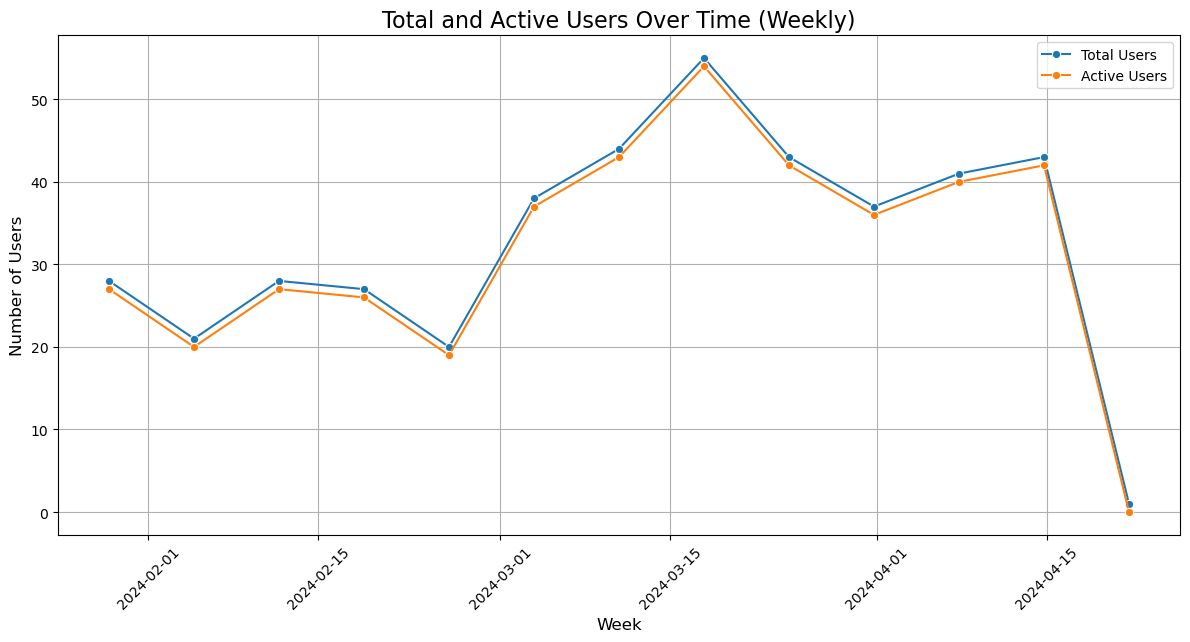

In [184]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta


query = """ 
        WITH user_data AS (
            SELECT 
                message_updated_at::DATE AS date, 
                masked_from_addr AS user_id,
                direction AS message_type
            FROM 
                l1_message_status
        ),
        max_date AS (
            SELECT MAX(message_updated_at::DATE) AS end_date
            FROM l1_message_status
        ),
        filtered_data AS (
            SELECT 
                u.date,
                u.user_id,
                u.message_type
            FROM 
                user_data u,
                max_date m
            WHERE 
                u.date >= (m.end_date - INTERVAL '12 weeks')
        ),
        weekly_data AS (
            SELECT
                date_trunc('week', date) AS week,
                user_id,
                message_type
            FROM 
                filtered_data
        ),
        total_users AS (
            SELECT 
                week,
                COUNT(DISTINCT user_id) AS total_users
            FROM 
                weekly_data
            GROUP BY 
                week
        ),
        active_users AS (
            SELECT 
                week,
                COUNT(DISTINCT user_id) AS active_users
            FROM 
                weekly_data
            WHERE 
                message_type = 'inbound'
            GROUP BY 
                week
        )
        SELECT 
            t.week,
            t.total_users,
            COALESCE(a.active_users, 0) AS active_users
        FROM 
            total_users t
        LEFT JOIN 
            active_users a ON t.week = a.week
        ORDER BY 
            t.week;

        """

# Fetch data from database
weekly_stats = fetch_table_db(engine, query)

print(weekly_stats)

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_stats, x='week', y='total_users', label='Total Users', marker='o')
sns.lineplot(data=weekly_stats, x='week', y='active_users', label='Active Users', marker='o')

plt.title('Total and Active Users Over Time (Weekly)', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

#### 2. The fraction of sent messages that are read, and the amount of time between when an outbound message is sent and when it is read.

##### a. Retriving all outbound messages that have a 'sent' status, along with their UUID, sent time, and the timestamp when the status was recorded.
##### b. Retrieving the messages from the sent_messages CTE that have a 'read' status, along with the timestamp of when the message was read (statuses table)
##### c. read_fraction: The fraction of sent messages that have been read, calculated by dividing the number of distinct 'read' messages by the number of distinct 'sent' messages
##### d. avg_time_to_read_minutes: The average time it takes for a message to be read, calculated as the average difference (in minutes) between the read timestamp and the sent timestamp.

Data fetched successfully


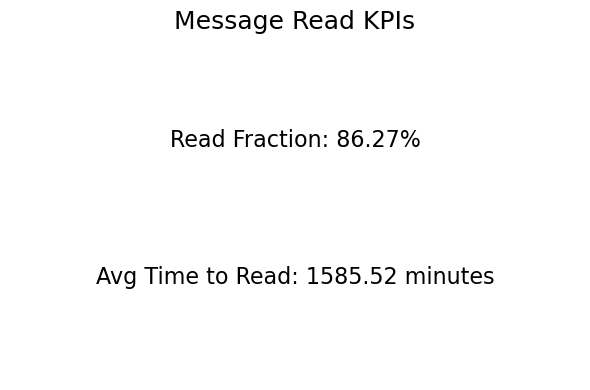

In [187]:
query = """
        WITH sent_messages AS (
        SELECT 
            m.uuid AS message_uuid,
            s.timestamp AS sent_time,
            s.status AS message_status,
            s.inserted_at AS status_timestamp
        FROM 
            l0_messages m
        LEFT JOIN 
            l0_statuses s ON m.uuid = s.message_uuid
        WHERE 
            m.direction = 'outbound'
            AND s.status = 'sent' 
    ),
    read_messages AS (
        SELECT 
            sent_messages.message_uuid,
            sent_messages.sent_time,
            s.timestamp AS status_timestamp
        FROM 
            sent_messages
        JOIN 
            l0_statuses s ON sent_messages.message_uuid = s.message_uuid
        WHERE 
            s.status = 'read' 
    )
    
    SELECT 
        COUNT(DISTINCT read_messages.message_uuid) * 1.0 / COUNT(DISTINCT sent_messages.message_uuid) AS read_fraction,
        AVG(EXTRACT(EPOCH FROM (read_messages.status_timestamp - read_messages.sent_time)) / 60) AS avg_time_to_read_minutes

    FROM 
        read_messages
    RIGHT JOIN 
        sent_messages ON read_messages.message_uuid = sent_messages.message_uuid;
        """

message_stats = fetch_table_db(engine, query)

# Plotting the data
read_fraction = message_stats['read_fraction'].iloc[0]
avg_time_to_read_minutes = message_stats['avg_time_to_read_minutes'].iloc[0]

plt.figure(figsize=(6, 4))

plt.text(0.5, 0.7, f"Read Fraction: {read_fraction * 100:.2f}%", fontsize=16, ha='center', va='center')
plt.text(0.5, 0.3, f"Avg Time to Read: {avg_time_to_read_minutes:.2f} minutes", fontsize=16, ha='center', va='center')

plt.axis('off')
plt.title('Message Read KPIs', fontsize=18)
plt.tight_layout()
plt.show()

#### 3. The number of outbound messages in the last week by status,e.g.,sent,
delivered read.

##### Below query retrieves the count of distinct outbound messages (grouped by status) sent in the last 365 days. It joins the l0_messages table with the l0_statuses table to fetch message status

Data fetched successfully
      status  message_count
0       sent           5099
1  delivered           4664
2       read           4612
3     failed            291


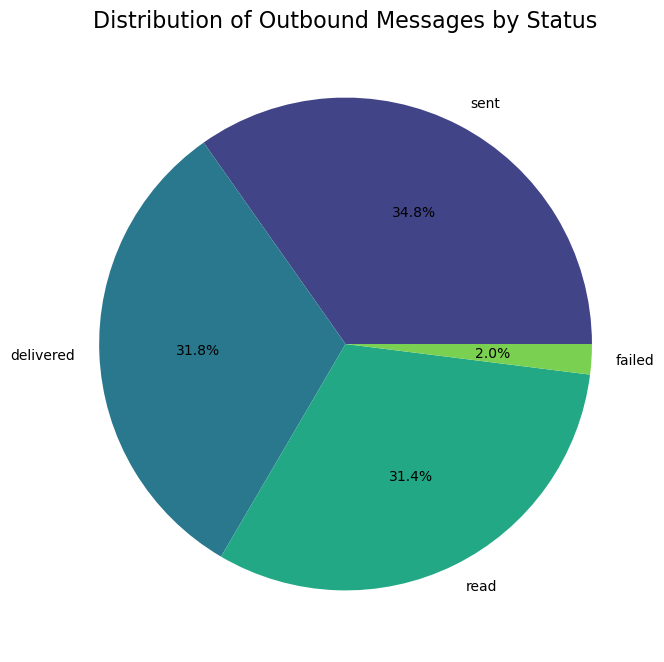

In [ ]:

query = """
        SELECT 
        s.status,
        COUNT(DISTINCT m.uuid) AS message_count
    FROM 
        l0_messages m
    JOIN 
        l0_statuses s ON m.uuid = s.message_uuid
    WHERE 
        m.direction = 'outbound' 
        AND s.inserted_at >= NOW() - INTERVAL '365 days'  
    GROUP BY 
        s.status
    ORDER BY 
        message_count DESC;
    """
# No data vailable for last 7 days, making it 365 to visulaise
message_last_week = fetch_table_db(engine, query)
print(message_last_week)

# Plotting data
plt.figure(figsize=(8, 8))

# Pie chart to show distribution of message statuses
plt.pie(message_last_week['message_count'], labels=message_last_week['status'], autopct='%1.1f%%', colors=sns.color_palette('viridis', len(message_last_week)))

# Adding title for the pie chart
plt.title('Distribution of Outbound Messages by Status', fontsize=16)
plt.show()